In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import scipy.io
from scipy.io import loadmat
import networkx as nx
import networkx
import math
pd.options.display.max_columns = 10

# Question One

#### Define some useful functions and load the data

In [2]:
def Matrix_D(W):
    # Generate Graph and Obtain Matrix D, \\
    # from weight matrix W defining the weight on the edge between each pair of nodes.
    # Note that you can assign sufficiently large weights to non-existing edges.

    n = np.shape(W)[0]
    Graph = nx.DiGraph()
    for i in range(n):
        for j in range(n):
            Graph.add_weighted_edges_from([(i,j,min(W[i,j], W[j,i]))])

    res = dict(nx.all_pairs_dijkstra_path_length(Graph))
    D = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            D[i,j] = res[i][j]
    np.savetxt('D.csv', D)
    return D

In [3]:
# Prepare dataframe for plot the images
mat = scipy.io.loadmat('data/isomap.mat')
df = pd.DataFrame(mat['images']).T
print(df.shape)

num_images, num_pixels = df.shape
pixels_per_dimension = int(math.sqrt(num_pixels))

# Rotate the pictures
for idx in df.index:
    df.loc[idx] = df.loc[idx].values.reshape(pixels_per_dimension, pixels_per_dimension).T.reshape(-1)
    
# Show first 5 rows
#print(df.head())

(698, 4096)


In [4]:
def plot_image(manifold_2D,df):
    
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline

    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111)
    ax.set_title('2D Components from Isomap of Facial Images')
    ax.set_xlabel('Component: 1')
    ax.set_ylabel('Component: 2')

    # Show 40 of the images ont the plot
    x_size = (max(manifold_2D['Component 1']) - min(manifold_2D['Component 1'])) * 0.08
    y_size = (max(manifold_2D['Component 2']) - min(manifold_2D['Component 2'])) * 0.08
    for i in range(40):
        img_num = np.random.randint(0, num_images)
        x0 = manifold_2D.loc[img_num, 'Component 1'] - (x_size / 2.)
        y0 = manifold_2D.loc[img_num, 'Component 2'] - (y_size / 2.)
        x1 = manifold_2D.loc[img_num, 'Component 1'] + (x_size / 2.)
        y1 = manifold_2D.loc[img_num, 'Component 2'] + (y_size / 2.)
        img = df.iloc[img_num,:].values.reshape(pixels_per_dimension, pixels_per_dimension)
        ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

    # Show 2D components plot
    ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)

    ax.set_ylabel('Up-Down Pose')
    ax.set_xlabel('Right-Left Pose')

    plt.show()

In [5]:
# load data for isomap implementation

images=loadmat('data/isomap.mat')['images']
print(images.shape)
num_pic=images.shape[1]
print(f"there are {num_pic} pictures")


(4096, 698)
there are 698 pictures


In [6]:
def isomap_eucleandian(data, num_neighbors, dim):

    #create edges list
    edges=[]
    for i in range(num_pic):
        for j in range(num_pic):
            dist = np.linalg.norm(data[:,i]-data[:,j])
            #dist = distance.cdist(images.T[i,:],images.T[j,:],"euclidean" )
            #dist = np.sum(np.abs(data[:,i]-data[:,j]))
            edges.append([i,j,dist])
    #print(len(edges))
    
    # create undirected weighted adjancy matrix
    G = networkx.Graph()
    for i in range(len(edges)):
        G.add_edge(edges[i][0], edges[i][1], weight=edges[i][2])
    A = networkx.adjacency_matrix(G).A    
    print(A.shape)
    
    #adjust weighted adjancy matrix entries based on different number of neighbors
    dim2=A.shape[0]
    A_adj=np.zeros([dim2,dim2])
    num_neighbors=num_neighbors
    for i in range(dim2):
        neighbors = np.argsort(A[i,:])[:num_neighbors+1]
        A_adj[i,neighbors] = A[i,neighbors]
        A_adj[neighbors,i] = A[neighbors,i]
    print(f"number of non-zero neighbors for each pic{np.count_nonzero(A_adj,axis=1)}") 
    
    # visulaize the adjency matrix
    G = nx.Graph(A_adj)
    nx.draw(G, with_labels=True)
    
    # adjsut the adjancy matrix to obtain shortest distance matrix
    A_adj2=A_adj
    A_adj2[A_adj==0]=np.inf
    #A_adj2
    D=Matrix_D(A_adj2)
    print(D.shape)
    
    # Compute the centering matrix H:
    m=D.shape[0]
    I = np.eye(N=m)
    H = I - 1/m * np.ones(m)
    dim=2

    # Compute the C matrix:
    C = (-1/(2) *np.dot(H ,D**2) ).dot( H)
    #print(C)

    # Compute the eigenvalues and eigenvectors of C and sort them in descending order:
    vals, vecs = np.linalg.eigh(C)
    sorted_vals = vals[np.argsort(-vals)]
    sorted_vecs = vecs[:,np.argsort(-vals)]
    # Normalize top eigenvectors and convert it into dataframe:
    Z = sorted_vecs[:,:dim] * np.sqrt(sorted_vals[:dim])
    manifold_2D = pd.DataFrame(Z, columns=['Component 1', 'Component 2']) 
    #manifold_2D.head()
    return manifold_2D, A_adj

## Question 1a

### Call the isomap implementation function and visualize the similarity graph

For this question, for each image, I use k=50 neighbors to create the weighted adjancy matrix.
I also apply networkx to visualize the weighted adjancy matrix a and printed out number of neighbors for each picture, to make sure at least 50 neighbors are selected for each picture. 

(698, 698)
number of non-zero neighbors for each pic[ 86  64  91  51  56  61  50  84  73  77  64  81  59  56  56  60  52  60
  64 104  69  78  61  51  68  57  52  50  72  83  58  55  68  62  55  57
  61  62  52  63  50  69  96  60  63  72  69  53  53  61  58  57  64  62
  71  75  56  51  65  59  50  66  65  50  50  51  74  50  69  80  55  54
  55  70  90  58  50  58  53  72  60  81  62  57  72  84  58  51  64  50
  71  56  57  64  66  62  50  55  58  58  50  50  51  61  64  51  84  63
  56  50  86  55  83  52  53  59  57  53  69  55  72  62  96  56  65  54
  53  76  79  61  51  63  56  58  73  76  53  72  91  59  52  60  76  54
  81  57  88  60  58  90  55  55  51  55  57  72  81  51  70  51  95  52
  54  55  62  50  50  50  75  54  53  61  56  61  61  96  61  57  58  50
  50  58  65  66  64  83  82  55  51  55  66  55  57  69  89  52  86  81
  59  75  68  61  51  61  80  50  59  71  68  51  73  54  71  66  64  69
  66  75  68  64  62  65  74  57  52  65  68  60  91  50  56  50  50  53

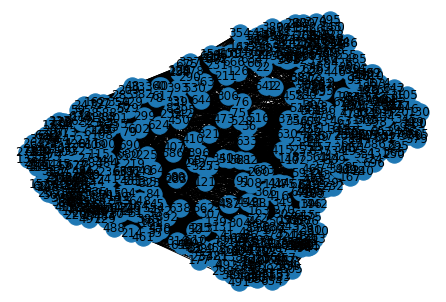

In [7]:
manifold_2D, A_adj=isomap_eucleandian(images, 50, 2)
print(manifold_2D.shape)

## Question 1 b
### Implement ISOMAP with two-dimentional embadding; show the lower dimentional embadding with a scatter plot and corresponding images

Based on the plot, I have observed that images with similar orientation/angles/facing directions are more likely to be clustered in the same group. For example, images on the left part of the plot are facing right angle, versus right part of faces are facing towards left angle. And faces on the bottom are more facing front.

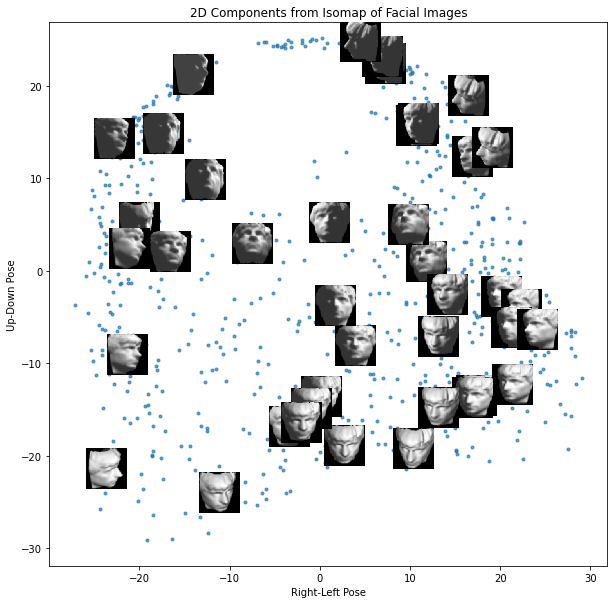

In [8]:
plot_image(manifold_2D,df)

## Question 1 c
### Implement ISOMAP with two-dimentional embadding, but with a different distance metric: L1 distance. Show the lower dimentional embadding with a scatter plot and corresponding images; Compare with what observed with L2 eucleadian distance.

The plotting results are slightly different using L1 distance versus L2 distance. With L1 distance, it shows slightly less clutering groups and not so distinct and clear clustering results as compared to L2 distance. For the images within the same clustering group in L1 distance, I can observe that some images have different orientations, not all images with same cluterings have similar orientations. Also, the location of images facing different directions are different compared to L2 distance. For example, images facing left direction are on the left side of the plot for L2 distance, versus L1 distance, images facing left/right directions are more likely to be on the bottom part of the plot.


In [9]:
def isomap_manhattan(data, num_neighbors, dim):

    #create edges list
    edges=[]
    for i in range(num_pic):
        for j in range(num_pic):
            #dist = np.linalg.norm(data[:,i]-data[:,j])
            #dist = distance.cdist(images.T[i,:],images.T[j,:],"euclidean" )
            dist = np.sum(np.abs(data[:,i]-data[:,j]))
            edges.append([i,j,dist])
    #print(len(edges))
    
    # create undirected weighted adjancy matrix
    G = networkx.Graph()
    for i in range(len(edges)):
        G.add_edge(edges[i][0], edges[i][1], weight=edges[i][2])
    A = networkx.adjacency_matrix(G).A    
    print(A.shape)
    
    #adjust weighted adjancy matrix entries based on different number of neighbors
    dim2=A.shape[0]
    A_adj=np.zeros([dim2,dim2])
    num_neighbors=num_neighbors
    for i in range(dim2):
        neighbors = np.argsort(A[i,:])[:num_neighbors+1]
        A_adj[i,neighbors] = A[i,neighbors]
        A_adj[neighbors,i] = A[neighbors,i]
    print(f"number of non-zero neighbors for each pic{np.count_nonzero(A_adj,axis=1)}") 
    
    # visulaize the adjency matrix
    G = nx.Graph(A_adj)
    nx.draw(G, with_labels=True)
    
    # adjsut the adjancy matrix to obtain shortest distance matrix
    A_adj2=A_adj
    A_adj2[A_adj==0]=np.inf
    #A_adj2
    D=Matrix_D(A_adj2)
    print(D.shape)
    
    # Compute the centering matrix H:
    m=D.shape[0]
    I = np.eye(N=m)
    H = I - 1/m * np.ones(m)
    dim=2

    # Compute the C matrix:
    C = (-1/(2) *np.dot(H ,D**2) ).dot( H)
    #print(C)

    # Compute the eigenvalues and eigenvectors of C and sort them in descending order:
    vals, vecs = np.linalg.eigh(C)
    sorted_vals = vals[np.argsort(-vals)]
    sorted_vecs = vecs[:,np.argsort(-vals)]
    # Normalize top eigenvectors and convert it into dataframe:
    Z = sorted_vecs[:,:dim] * np.sqrt(sorted_vals[:dim])
    manifold_2D = pd.DataFrame(Z, columns=['Component 1', 'Component 2']) 
    #manifold_2D.head()
    return manifold_2D, A_adj

In [ ]:
manifold_2D_m, A_adj_m=isomap_manhattan(images, 50, 2)
print(manifold_2D_m.shape)
plot_image(manifold_2D_m,df)

(698, 698)
number of non-zero neighbors for each pic[ 77  68  82  51  57  60  52  74  86  69  63  76  59  54  56  63  52  61
  58  89  73  72  58  51  68  56  54  50  87  96  68  54  76  63  55  55
  59  64  57  57  50  75 107  67  64  70  73  53  55  64  58  57  63  62
  71  75  57  51  71  60  50  63  71  50  50  51  79  50  60  65  55  52
  56  83  80  54  51  57  54  58  54  74  57  56  64  85  68  51  59  50
  63  51  56  63  65  60  50  56  61  58  50  55  52  63  61  52 101  68
  51  54  94  60  76  54  57  59  53  58  68  53  68  59  88  54  72  57
  64  77  69  58  55  68  57  64  73  62  51  73  89  62  60  57  86  56
  73  67  82  58  58  79  60  54  52  54  66  82  67  50  74  56 107  58
  55  61  52  50  50  50  90  57  53  63  57  67  65  89  66  66  59  51
  50  55  56  64  62  90  79  59  53  56  68  55  57  70  77  52  86  75
  53  82  64  67  50  64  78  50  55  69  67  53  74  65  68  61  68  73
  66  82  65  56  60  71  76  59  58  54  75  60  79  50  62  53  50  50

## Question 1 d
### Perfrom PCA on the images and project images on top 2 principle components. Compare the embaddings with PCA versus ISOMAP.
By comparing below PCA plots with L2 ISOMAP, the results are not as clearly seperable as L2 ISOMAP. So with PCA, clearly, we can not obtain a more meaningful projection as compared to ISOMAP, as images with different orientations can be clustered together.

In [ ]:
# Perform PCA on the images and project it into two dimentional space
#Import required modules
from sklearn.decomposition import PCA
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(images.T)
converted_data.shape
converted_data_2D = pd.DataFrame(converted_data, columns=['Component 1', 'Component 2']) 


In [ ]:
plot_image(converted_data_2D,df)

# Question 2

## Question 2a one-dimentional plot

In [ ]:
data = pd.read_csv('data/n90pol.csv')
data.head()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import iqr
# calculate optimal bandwidth and number of bins based on interquartile ranges
iqr=iqr(data.iloc[:,0])
bw =2 * iqr / len(data)**(1/3)
bins=int((max(data.iloc[:,0])-min(data.iloc[:,0]))/bw)
plt.hist(data.iloc[:,0],bins=bins);
print(iqr)
print(bins)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import iqr
iqr=iqr(data.iloc[:,1])
bw =2 * iqr / len(data)**(1/3)
bins=int((max(data.iloc[:,1])-min(data.iloc[:,1]))/bw)
plt.hist(data.iloc[:,1],bins=bins);
print(iqr)
print(bins)

In [ ]:
import seaborn as sns
#tips = sns.load_dataset("tips")
#sns.kdeplot(data=tips, x="total_bill")
#sns.kdeplot(data=data, x=data.iloc[:,0])
#tips
#fig, ax = plt.subplots(1,2)
std=np.std(data.iloc[:,0])
n=len(data)
bandwidth=1.06*n**(-1/5)
sns.kdeplot(data=data, x=data.iloc[:,0],bw_adjust=bandwidth)
std
bandwidth

In [ ]:
std=np.std(data.iloc[:,1])
n=len(data)
bandwidth=1.06*n**(-1/5)
sns.kdeplot(data=data, x=data.iloc[:,1],bw_adjust=bandwidth)

## Question 2b 
Form 2-dimentional histogram for pairs of variables amydala and acc

In [ ]:
fig = plt.subplots(figsize =(10, 7)) 
# Creating plot 
plt.hist2d(data.iloc[:,0],data.iloc[:,1]) 
plt.title("Simple 2D Histogram") 
plt.colorbar() 
plt.xlabel('amygdala')
plt.ylabel('acc')

## Question 2c
Use KDE to estimate 2-dimentional kernal density function for amygdala and acc and from there infer whether whether the two variables are independent or not. 

Based on the observation from the kernal density contour plot, since the shape of contour plot is an elipse not a circle, we can conclude that X and Y are likely to be correlated, meaning X contains information about y or we can use X to infer Y.

In addition, I also calucate the absolute difference of abs(p(x)*p(y)-p(x*y), plotting the difference histogram and scatter plot of the joint versus product of marginal distributions. Based on observations from histogram and scatter plot, I can conclude that the differnce between those two are large, and also the scatter plot shows a roughly linear trend between those two variables. Therefore, I conclude that the two variables are not independent.

In [ ]:
import seaborn as sns
#bandwidth=1.06*n**(-1/5)
sns.kdeplot(data=data, x=data.iloc[:,0], y=data.iloc[:,1],fill=True)

In [ ]:
from sklearn.neighbors import KernelDensity
n=len(data)
sigma1=np.std(data.iloc[:,0])
sigma2=np.std(data.iloc[:,1])
sigma3=np.std(data.iloc[:,0]*data.iloc[:,1])
band1=1.06*sigma1*n**(-1/5)
band2=1.06*sigma2*n**(-1/5)
band3=1.06*sigma3*n**(-1/5)


#joint
data_joint=pd.DataFrame(data.iloc[:,0]*data.iloc[:,1])
kde_joint = KernelDensity(kernel='gaussian', bandwidth=band3).fit(data_joint)
s_joint=pd.DataFrame(kde_joint.score_samples(data_joint))

# marginal1
kde1 = KernelDensity(kernel='gaussian', bandwidth=band1).fit(pd.DataFrame(data.iloc[:,0]))
s1=pd.DataFrame(kde1.score_samples(pd.DataFrame(data.iloc[:,0])))

#marginal2
kde2 = KernelDensity(kernel='gaussian', bandwidth=band2).fit(pd.DataFrame(data.iloc[:,1]))
s2=pd.DataFrame(kde2.score_samples(pd.DataFrame(data.iloc[:,1])))
s_m=s1*s2

# calucalte absolute difference of product of marginal versus joint and plot histogram of difference
diff=abs(s_joint-s_m)
plt.hist(diff)




In [ ]:
#draw a scatter plot of marginal versus joint
df=pd.concat([s_m,s_joint],axis=1)
df.columns=['marginal','joint']
#sns.heatmap(df)
#df
plt.scatter(df.iloc[:,0], df.iloc[:,1], marker='o');
# not independent

## Question 2d
Plot one-dimentional KDE for amygdala and acc conditional on political orientations and infer whether brain structure has something to do with political orientation.

Based on the eight one-dimentional kernal density plot for each of the variable with respect to their different political orientations, we can observe that for amygdala:
The four distributions have some overlaps;
However, the shapes seem to be similar,i.e the peaks adn valleys seem to occur  at the same locations;
For orientation=2, there is a second peak when data in ranges around 0.04-0.075 on the tail, the shape is unique only in this orientation;
For orientation=5, it seems that the peaks happens in the middle range of data.
So it seems different orientations has different brain size distributions.

For acc,the shape of the four distributions diff.
For orientation=4/5, the peaks happen when data ranges relatively small; and density is very large.
For other orientations, the peaks happen when data is in the middle range, and density is relatively smaller. 
So different orientations have different distribution shapes.

Sample mean see table below.

In [ ]:
n=len(data)
bandwidth=1.06*n**(-1/5)
sns.kdeplot(
   data=data, x=data.iloc[:,0], hue=data.iloc[:,2],
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0,bw_adjust=bandwidth
)

In [ ]:
n=len(data)
bandwidth=1.06*n**(-1/5)
sns.kdeplot(
   data=data, x=data.iloc[:,1], hue=data.iloc[:,2],
   fill=True, common_norm=False, palette="husl",
   alpha=.5, linewidth=0,bw_adjust=bandwidth
)

In [ ]:
#sample mean for amygdala and acc conditional on orientation
d1=data.groupby('orientation', as_index=False)['amygdala'].mean()
d2=data.groupby('orientation', as_index=False)['acc'].mean()
d3=d1.merge(d2).T.iloc[1:,:]
#d3=d3.rename(columns={'c=2','c=3','c=4','c=5'})
#d3
d3.columns=['c=2','c=3','c=4','c=5']
print(d3)

## Question 2e

In [ ]:
#n=len(data)
#bandwidth=1.06*n**(-1/5)
sns.kdeplot(
   data=data, x=data.iloc[:,0],y=data.iloc[:,1] ,hue=data.iloc[:,2],
   fill=True, common_norm=False, palette="husl",
   alpha=.5, linewidth=0,
)